# Online Payment Fraud Detection

Goal : To detect fraudulent online payment transactions in real time in order to reduce financial loss and improve customer trust.

Problem Type : Binary Classification

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, ConfusionMatrixDisplay

In [39]:
# Load Dataset
df = pd.read_csv('online_payments_fraud.csv')

In [40]:
# First 5 rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,103,CASH_IN,1607.76,C682167,984.02,10770.80,M303873,1837.70,851.21,0,0
1,436,TRANSFER,182.95,C144873,1836.00,5730.53,M817898,3983.21,2072.69,0,0
2,271,PAYMENT,1671.07,C841266,2425.75,3933.55,M825387,7233.66,8478.29,0,0
3,107,TRANSFER,3159.24,C306189,5885.74,5373.85,M757888,3623.44,20789.19,0,0
4,72,DEBIT,4731.89,C926293,1220.72,4678.28,M683593,6179.77,4892.04,0,0


In [41]:
# Random 5 rows
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
163402,549,CASH_OUT,819.90,C298523,2843.91,2693.60,M379886,1475.58,9749.71,0,0
4612,544,TRANSFER,129.80,C265292,1820.88,778.09,M646564,14950.33,2336.98,0,0
170630,203,TRANSFER,182.60,C362863,1884.12,8061.12,M972695,113.22,8524.44,0,0
130307,635,TRANSFER,5364.02,C994069,4623.76,2472.02,M601810,11081.13,1499.05,0,0
174019,355,CASH_OUT,1719.32,C686675,2835.29,1233.87,M247740,6292.97,10730.09,0,0


In [42]:
# Shape of dataset
df.shape

(200000, 11)

In [43]:
# Column names
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            200000 non-null  int64  
 1   type            200000 non-null  object 
 2   amount          200000 non-null  float64
 3   nameOrig        200000 non-null  object 
 4   oldbalanceOrg   200000 non-null  float64
 5   newbalanceOrig  200000 non-null  float64
 6   nameDest        200000 non-null  object 
 7   oldbalanceDest  200000 non-null  float64
 8   newbalanceDest  200000 non-null  float64
 9   isFraud         200000 non-null  int64  
 10  isFlaggedFraud  200000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 16.8+ MB


In [45]:
# Check missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [46]:
# Check duplicated rows
df.duplicated().sum()

0

In [47]:
# Statisical description
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0
mean,374.998190,1996.923487,5009.776236,5021.849831,6985.004298,6980.025699,0.001870,0.0
std,216.271827,1991.484816,5008.436659,5028.221638,7006.638020,6978.969420,0.043203,0.0
min,1.000000,0.000000,0.070000,0.000000,0.020000,0.000000,0.000000,0.0
25%,187.000000,575.427500,1447.420000,1439.485000,2007.127500,2016.092500,0.000000,0.0
50%,375.000000,1389.270000,3462.695000,3488.395000,4826.600000,4850.025000,0.000000,0.0
75%,563.000000,2768.137500,6945.785000,6954.625000,9662.722500,9675.287500,0.000000,0.0
max,749.000000,26587.320000,60960.690000,58234.520000,82099.420000,85770.690000,1.000000,0.0


# Dataset Observation : 
- Dataset have 200000 Rows and 11 Columns.
- Dataset have mix data type columns categorical or numeric.
- No missing values present in dataset.
- No duplicated rows present in dataset.

# EDA

Target variable distribution

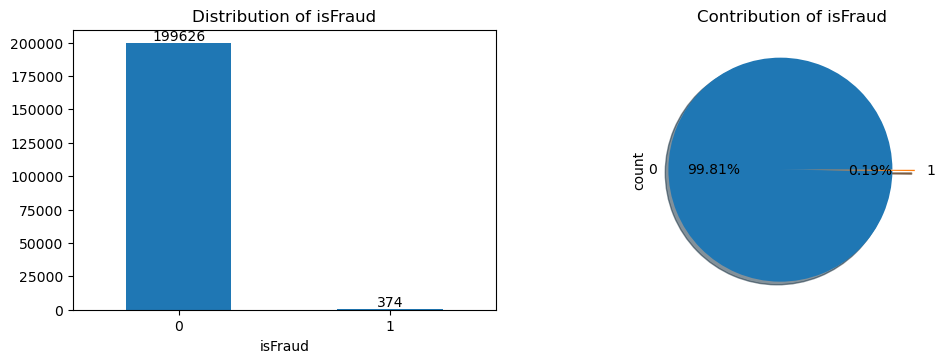

In [48]:
plt.figure(figsize = (12,8))
ax = plt.subplot(2,2,1)
plt.title('Distribution of isFraud')
bars = df['isFraud'].value_counts().plot(kind = 'bar', ax = ax)
df['isFraud'].value_counts()
plt.xticks(rotation = 0)
ax.bar_label(bars.containers[0])

plt.subplot(2,2,2) 
plt.title('Contribution of isFraud')
df['isFraud'].value_counts().plot(kind = 'pie', explode = [0.1,0.1], autopct = '%.2f%%', shadow = True);

Type column distribution

([0, 1, 2, 3, 4],
 [Text(0, 0, 'CASH_IN'),
  Text(1, 0, 'TRANSFER'),
  Text(2, 0, 'PAYMENT'),
  Text(3, 0, 'DEBIT'),
  Text(4, 0, 'CASH_OUT')])

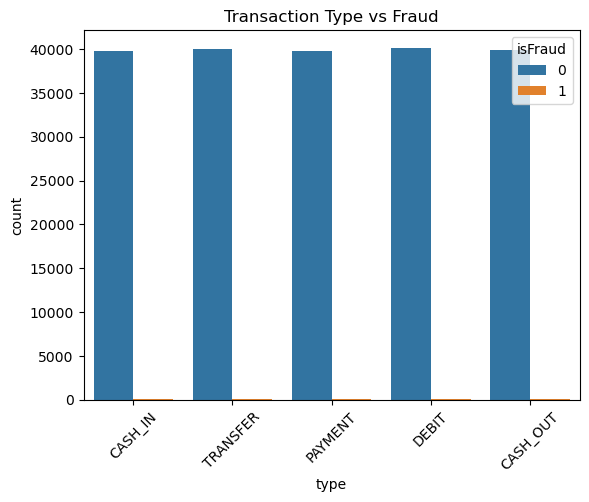

In [49]:
sns.countplot(
x = 'type',
hue = 'isFraud',
data = df
)
plt.title("Transaction Type vs Fraud")
plt.xticks(rotation=45)

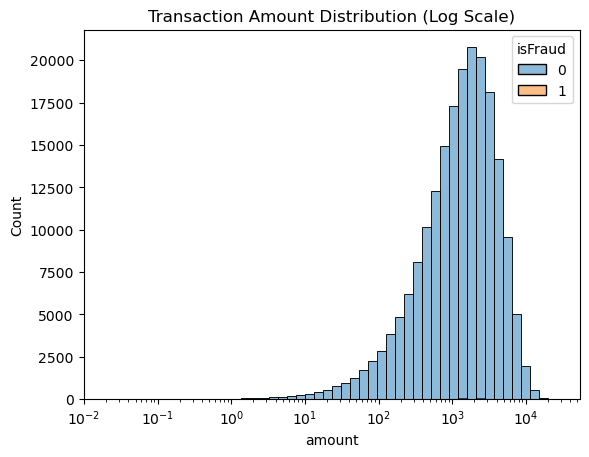

In [50]:
sns.histplot(
data = df,
x = 'amount',
hue = 'isFraud',
log_scale = True,
bins = 50
)
plt.title("Transaction Amount Distribution (Log Scale)");

In [51]:
df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_orig']

0         -9786.78
1         -3894.53
2         -1507.80
3           511.89
4         -3457.56
            ...   
199995    13539.20
199996    -5589.68
199997    15957.98
199998      -48.49
199999     1547.39
Name: balance_diff_orig, Length: 200000, dtype: float64

Text(0.5, 1.0, 'Fraud Transactions Over Time')

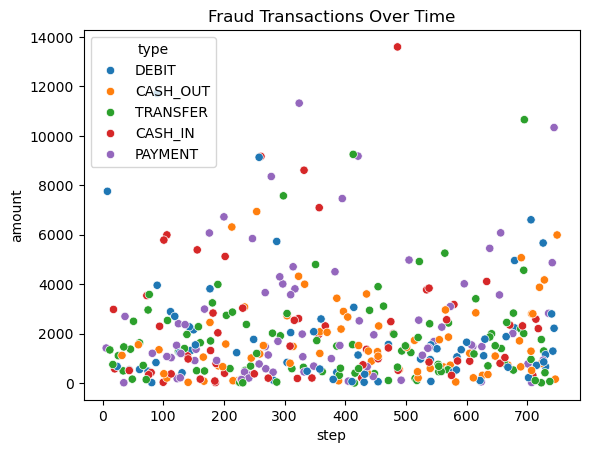

In [52]:
sns.scatterplot(
x = 'step',
y = 'amount',
hue = 'type',
data = df[df['isFraud'] == 1],
)
plt.title("Fraud Transactions Over Time")

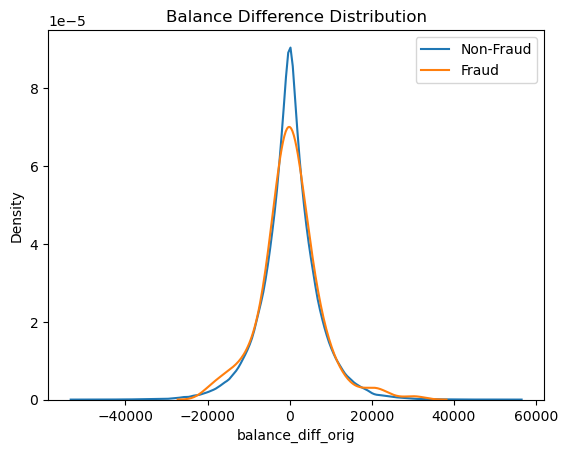

In [53]:
sns.kdeplot(
df[df['isFraud'] == 0]['balance_diff_orig'],
label='Non-Fraud'
)
sns.kdeplot(
df[df['isFraud'] == 1]['balance_diff_orig'],
label='Fraud'
)
plt.title("Balance Difference Distribution")
plt.legend()

Text(0.5, 1.0, 'Amount difference by fraud status')

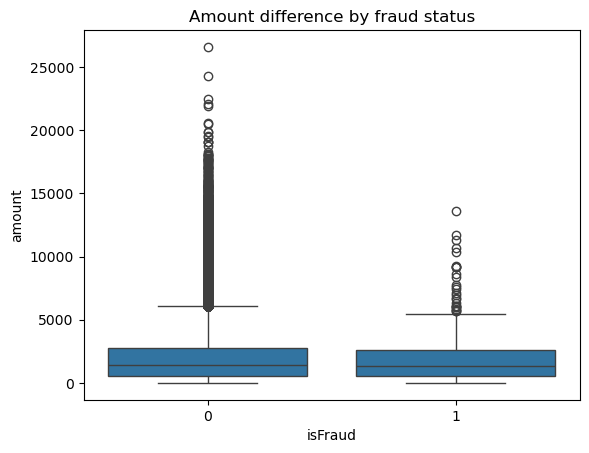

In [54]:
sns.boxplot(x = df['isFraud'], y = df['amount'])
plt.title('Amount difference by fraud status')

Text(0.5, 1.0, 'Balance Difference (Origin) by Fraud Status')

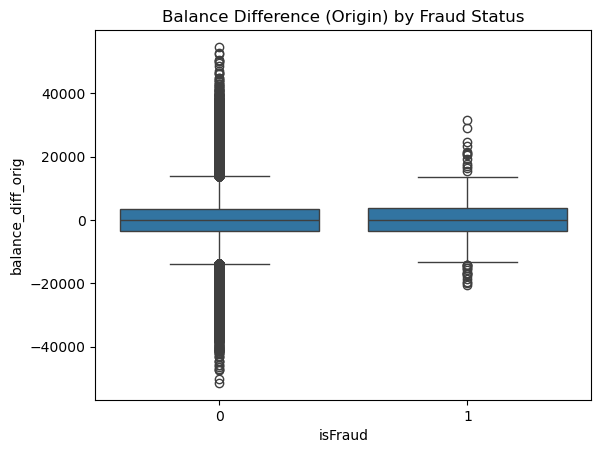

In [55]:
sns.boxplot(
x='isFraud',
y='balance_diff_orig',
data=df
)
plt.title("Balance Difference (Origin) by Fraud Status")

Text(0.5, 1.0, 'Correlations of Columns')

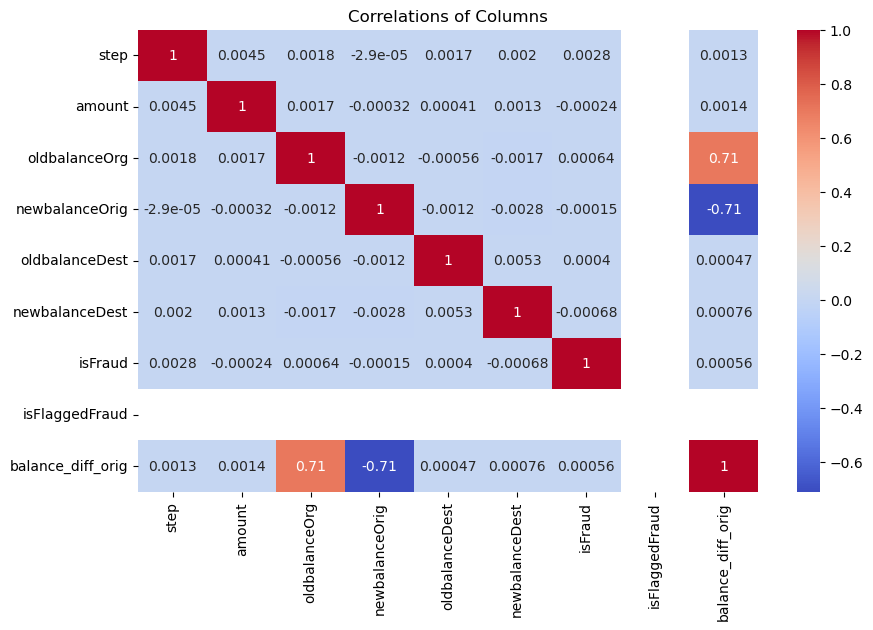

In [56]:
plt.figure(figsize=(10,6))
cor = df.select_dtypes(include = ['int64','float64'])
corr = cor.corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm')
plt.title('Correlations of Columns')

# Exploratory Data Analysis (EDA) Summary

- The dataset is extremely imbalanced, with fraudulent transactions representing a very small fraction of the total data. This makes accuracy an unreliable evaluation metric and highlights the importance of recall, F1-score, and ROC-AUC.

- Transaction amounts are heavily right-skewed. Fraudulent transactions occur across both low and high amounts, indicating that transaction amount alone is insufficient to detect fraud.

- Fraudulent activity is more frequent in specific transaction types, particularly TRANSFER and CASH_OUT, making transaction type a strong categorical feature for fraud detection.

- Fraud transactions are distributed across the entire timeline and are not restricted to a specific time window. Temporal features provide supporting signal but are not sufficient on their own.

- Raw account balance values show significant overlap between fraud and non-fraud cases. However, engineered balance difference features reveal abnormal transaction behavior and provide stronger discriminatory power.


# Data Preprocessing

In [57]:
# Drop identifier columns because it not help in prediction and drop isFlaggedFraud because this column adds no predictive value.
df = df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis = 1)

Separate Target and Features

In [58]:
X = df.drop(['isFraud'], axis = 1) 
y = df['isFraud']

Separate Training and Testing data

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

Separate Categorical and Numeric Columns

In [60]:
cat_cols = ['type']
num_cols = X.select_dtypes(include = ['int64', 'float64']).columns

In [61]:
cat_pipe = Pipeline(steps = [
    ('encoder', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'))
])

In [62]:
num_pipe = Pipeline(steps = [
    ('scaler', StandardScaler())
])

In [63]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_pipe, num_cols), 
        ('cat', cat_pipe, cat_cols)
    ]
)

Evaluation Function

In [64]:
def evaluation(model, X_train, X_test, y_train, y_test, model_name = ''): 

    results = {'Model Name' : model_name}
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    results['roc_auc_score_mean'] = None

    if hasattr(model, 'predict_proba'): 
        cv_score = cross_val_score(
            model, 
            X_train,
            y_train, 
            cv = cv, 
            scoring = 'roc_auc'
        )
        results['roc_auc_score_mean'] = cv_score.mean() 

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results.update({
        'Train_accuracy' : accuracy_score(y_train, y_train_pred),
        'Test_accuracy' : accuracy_score(y_test, y_test_pred), 
        'Train_recall' : recall_score(y_train, y_train_pred),
        'Test_recall' : recall_score(y_test, y_test_pred), 
        'Train_precision' : precision_score(y_train, y_train_pred), 
        'Test_precision' : precision_score(y_test, y_test_pred),
        'Train_f1_score' : f1_score(y_train, y_train_pred), 
        'Test_f1_score' : f1_score(y_test, y_test_pred)
    })

    if hasattr(model, 'predict_proba'): 
        y_test_proba = model.predict_proba(X_test)[:,1]
        results['ROC_AUC_TEST'] = roc_auc_score(y_test, y_test_proba)

    return results

ConfusionMatrixDisplay function

In [65]:
def cmd(model, X_test, y_test): 
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test, 
        y_test, 
        display_labels = model.classes_, 
        cmap = 'Blues'
    )

# Model Building

# Logistic Regression

In [66]:
lr_pipe = ImbPipeline(steps = [
    ('preprocessor', preprocessor), 
    ('smote', SMOTE(random_state = 42)), 
    ('model', LogisticRegression(max_iter = 1000))
])

In [67]:
lr_metrics = evaluation(lr_pipe, X_train, X_test, y_train, y_test, model_name = 'Logistic Regression')
lr_metrics

{'Model Name': 'Logistic Regression',
 'roc_auc_score_mean': 0.5105959120579264,
 'Train_accuracy': 0.5225375,
 'Test_accuracy': 0.521325,
 'Train_recall': 0.5384615384615384,
 'Test_recall': 0.4666666666666667,
 'Train_precision': 0.002106861038774095,
 'Test_precision': 0.0018284400794065406,
 'Train_f1_score': 0.004197299129255957,
 'Test_f1_score': 0.003642608107404902,
 'ROC_AUC_TEST': 0.4820104362346066}

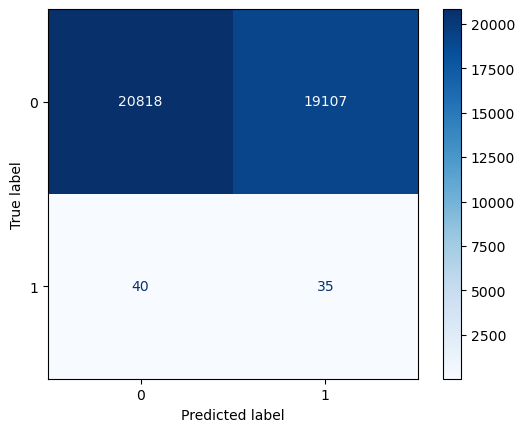

In [68]:
lr_cmd = cmd(lr_pipe,X_test, y_test)

# Decision Tree

In [69]:
dt_pipe = ImbPipeline(steps = [
    ('preprocessor', preprocessor), 
    ('model', DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 3, min_samples_split = 5, random_state = 42, class_weight = 'balanced'))
])

In [70]:
dt_metrics = evaluation(dt_pipe, X_train, X_test, y_train, y_test, model_name = 'Decision Tree')
dt_metrics

{'Model Name': 'Decision Tree',
 'roc_auc_score_mean': 0.49597539609873326,
 'Train_accuracy': 0.6853875,
 'Test_accuracy': 0.68265,
 'Train_recall': 0.5117056856187291,
 'Test_recall': 0.37333333333333335,
 'Train_precision': 0.0030390306882510675,
 'Test_precision': 0.0022090729783037473,
 'Train_f1_score': 0.00604217676328884,
 'Test_f1_score': 0.004392156862745098,
 'ROC_AUC_TEST': 0.5215515758714255}

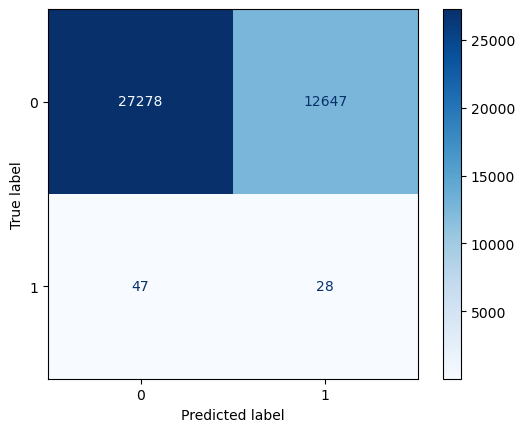

In [71]:
dt_cmd = cmd(dt_pipe, X_test, y_test)

# Random Forest

In [72]:
rf_pipe = ImbPipeline(steps = [
    ('preprocessor', preprocessor), 
    ('model', RandomForestClassifier(n_estimators = 200, n_jobs = -1, max_depth = 5, min_samples_leaf = 3, min_samples_split = 5, random_state = 42, class_weight = 'balanced'))
])

In [73]:
rf_metrics = evaluation(rf_pipe, X_train, X_test, y_train, y_test, model_name = 'Random Forest')
rf_metrics

{'Model Name': 'Random Forest',
 'roc_auc_score_mean': 0.5147962388214389,
 'Train_accuracy': 0.914375,
 'Test_accuracy': 0.911375,
 'Train_recall': 0.5819397993311036,
 'Test_recall': 0.02666666666666667,
 'Train_precision': 0.012655465852061967,
 'Test_precision': 0.0005757052389176742,
 'Train_f1_score': 0.024772209567198177,
 'Test_f1_score': 0.0011270780501549732,
 'ROC_AUC_TEST': 0.4427034022124818}

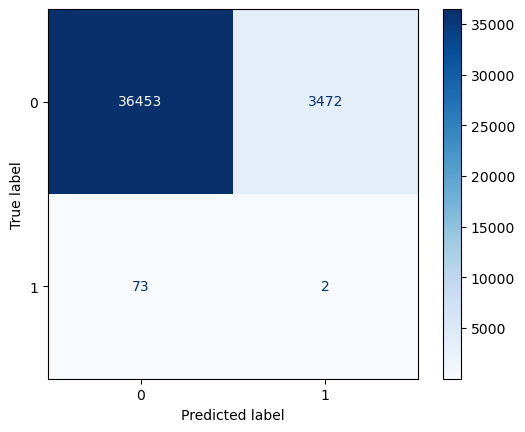

In [74]:
rf_cmd = cmd(rf_pipe, X_test, y_test)

# Threshold Tuning

In [76]:
def threshold_tuning(model, X_train, X_test, y_train, y_test, thresholds = None, model_name = ''):

    if thresholds is None:
        thresholds = [0.05, 0.1, 0.2, 0.3, 0.4]

    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]

    results = []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)

        results.append({
            'Model Name': model_name,
            'Threshold': t,
            'Recall': recall_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'F1_score': f1_score(y_test, y_pred)
        })

    return pd.DataFrame(results)

In [77]:
threshold_results = threshold_tuning(
    rf_pipe,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Random Forest'
)

threshold_results

,Model Name,Threshold,Recall,Precision,F1_score
0,Random Forest,0.05,1.00,0.001875,0.003743
1,Random Forest,0.10,1.00,0.001875,0.003743
2,Random Forest,0.20,1.00,0.001875,0.003743
3,Random Forest,0.30,1.00,0.001890,0.003772
4,Random Forest,0.40,0.72,0.001770,0.003531


Final threshold is 0.3 because it provede better results than other threshold.

In [93]:
final_threshold = 0.3
y_prob = rf_pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= final_threshold).astype(int)

In [94]:
print('Test_recall', recall_score(y_test, y_pred)),
print('Test_precision', precision_score(y_test, y_pred)),
print('Test_f1_score', f1_score(y_test, y_pred))

Test_recall 1.0
Test_precision 0.001889501927291966
Test_f1_score 0.003771876885938443


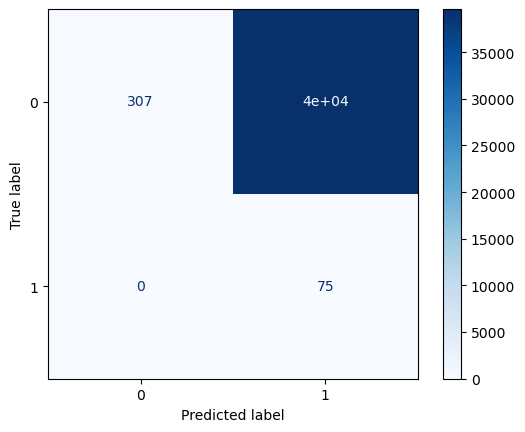

In [88]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues')

# Conclusion

Due to extreme class imbalance, accuracy was not a reliable metric for this problem. By using class-weight balancing and probability-based threshold tuning, the model achieved 100% recall, ensuring that no fraudulent transactions were missed. Although this resulted in low precision due to many false positives, the trade-off is acceptable in fraud detection scenarios where minimizing missed fraud is the primary objective.